In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import os

In [2]:
os.makedirs("models", exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 30
# Hyperparameters from LeCun et al. (1998)
J = torch.tensor(5)
A = 1.7159
S = 2./3.

In [3]:
transform = transforms.Compose([
    transforms.Pad(2),      
    transforms.ToTensor(),
])

train_dataset = MNIST(root=".", train=True, download=False, transform=transform)
test_dataset = MNIST(root=".", train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Loss function from LeCun et al. (1998)
def loss_fn(imgs, labels):
    outputs = model(imgs)
    B = imgs.size(0)
    correct_penalty = outputs[torch.arange(B, device=labels.device), labels]
    log_sum = torch.logsumexp(-outputs, dim=1) 
    j = torch.as_tensor(J, device=outputs.device, dtype=outputs.dtype)
    log_term = torch.logaddexp(-j, log_sum)
    return (correct_penalty + log_term).mean()

# LeNet-5 PyTorch

In [4]:
class Tanh(nn.Module):
    def __init__(self, a, s):
        super().__init__()
        self.a = a
        self.s = s

    def forward(self, x):
        x = self.a * torch.tanh(self.s * x)
        return x

# Final layer from LeCun et al. (1998)
class RBFOutputLayer(nn.Module):
    def __init__(self, num_classes, num_features, prototypes=None, requires_grad=False):
        super().__init__()
        if prototypes is not None:
            self.prototypes = nn.Parameter(prototypes, requires_grad=requires_grad)
        else:
            self.prototypes = nn.Parameter(
                (torch.randint(0, 2, (num_classes, num_features)) * 2 - 1).float(),
                requires_grad=requires_grad
            )

    def forward(self, x):
        # x: [batch, num_features], prototypes: [num_classes, num_features]
        x = x.unsqueeze(1)  # [batch, 1, num_features]
        w = self.prototypes.unsqueeze(0)  # [1, num_classes, num_features]
        dists = torch.sum((x - w) ** 2, dim=2)  # [batch, num_classes]
        return dists

In [5]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        fan_in = 1 * 5 * 5
        torch.nn.init.uniform_(self.conv1.weight, -1/fan_in, 1/fan_in)
        torch.nn.init.zeros_(self.conv1.bias)

        self.tanh1 = Tanh(A, S)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.tanh2 = Tanh(A, S)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        fan_in = 6 * 5 * 5
        torch.nn.init.uniform_(self.conv2.weight, -1/fan_in, 1/fan_in)
        torch.nn.init.zeros_(self.conv2.bias)

        self.tanh3 = Tanh(A, S)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.tanh4 = Tanh(A, S)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        fan_in = 16 * 5 * 5
        torch.nn.init.uniform_(self.conv3.weight, -1/fan_in, 1/fan_in)
        torch.nn.init.zeros_(self.conv3.bias)

        self.tanh5 = Tanh(A, S)
        self.linear = nn.Linear(120, 84)
        fan_in = 120
        torch.nn.init.uniform_(self.linear.weight, -1/fan_in, 1/fan_in)
        torch.nn.init.zeros_(self.linear.bias)
        
        self.tanh6 = Tanh(A, S)
        self.rbf = RBFOutputLayer(num_classes, 84, requires_grad=False)
        fan_in = 10
        torch.nn.init.uniform_(self.rbf.prototypes, -1/fan_in, 1/fan_in)

    def forward(self, x):
        x = self.tanh1(self.conv1(x))
        x = self.tanh2(self.pool1(x))
        x = self.tanh3(self.conv2(x))
        x = self.tanh4(self.pool2(x))
        x = self.tanh5(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.tanh6(self.linear(x))
        x = self.rbf(x)
        return x

In [6]:
model = LeNet5()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    for imgs, labels in train_bar:
        imgs.to(device)
        labels.long().to(device)

        optimizer.zero_grad(set_to_none=True)
        loss = loss_fn(imgs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Eval]", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs = imgs.to(device)
            labels = labels.long().to(device)

            outputs = model(imgs)
            loss = loss_fn(imgs, labels)
            val_loss += loss.item()

            preds = outputs.argmin(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_acc = 100.0 * correct / total

    print(f"Epoch {epoch+1} - Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f} | Val acc: {val_acc:.2f}%")


torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_loss": avg_train_loss,
    "val_loss": avg_val_loss,
    "val_acc": val_acc
}, os.path.join("models", "lenet-5_mnist_checkpoint.pth"))

Epoch 1/30 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1 - Train loss: 1.1396 | Val loss: 0.8656 | Val acc: 93.23%


Epoch 2 - Train loss: 0.8296 | Val loss: 0.7798 | Val acc: 95.52%


Epoch 3 - Train loss: 0.7678 | Val loss: 0.7435 | Val acc: 96.96%


Epoch 4 - Train loss: 0.7335 | Val loss: 0.7149 | Val acc: 97.69%


Epoch 5 - Train loss: 0.7161 | Val loss: 0.7134 | Val acc: 97.85%


Epoch 6 - Train loss: 0.7044 | Val loss: 0.7069 | Val acc: 98.33%


Epoch 7 - Train loss: 0.6963 | Val loss: 0.7023 | Val acc: 98.14%


Epoch 8 - Train loss: 0.6917 | Val loss: 0.6930 | Val acc: 98.40%


Epoch 9 - Train loss: 0.6866 | Val loss: 0.6861 | Val acc: 98.54%


Epoch 10 - Train loss: 0.6835 | Val loss: 0.6829 | Val acc: 98.59%


Epoch 11 - Train loss: 0.6796 | Val loss: 0.6783 | Val acc: 98.68%


Epoch 12 - Train loss: 0.6770 | Val loss: 0.6817 | Val acc: 98.59%


Epoch 13 - Train loss: 0.6741 | Val loss: 0.6741 | Val acc: 98.78%


Epoch 14 - Train loss: 0.6719 | Val loss: 0.6768 | Val acc: 98.78%


Epoch 15 - Train loss: 0.6707 | Val loss: 0.6718 | Val acc: 98.85%


Epoch 16 - Train loss: 0.6688 | Val loss: 0.6710 | Val acc: 98.81%


Epoch 17 - Train loss: 0.6674 | Val loss: 0.6747 | Val acc: 98.71%


Epoch 18 - Train loss: 0.6662 | Val loss: 0.6718 | Val acc: 98.80%


Epoch 19 - Train loss: 0.6651 | Val loss: 0.6714 | Val acc: 98.81%


Epoch 20 - Train loss: 0.6635 | Val loss: 0.6663 | Val acc: 99.01%


Epoch 21 - Train loss: 0.6624 | Val loss: 0.6720 | Val acc: 98.91%


Epoch 22 - Train loss: 0.6618 | Val loss: 0.6665 | Val acc: 98.99%


Epoch 23 - Train loss: 0.6606 | Val loss: 0.6667 | Val acc: 99.05%


Epoch 24 - Train loss: 0.6598 | Val loss: 0.6643 | Val acc: 99.02%


Epoch 25 - Train loss: 0.6588 | Val loss: 0.6657 | Val acc: 98.95%


Epoch 26 - Train loss: 0.6585 | Val loss: 0.6686 | Val acc: 98.85%


Epoch 27 - Train loss: 0.6576 | Val loss: 0.6668 | Val acc: 99.03%


Epoch 28 - Train loss: 0.6565 | Val loss: 0.6648 | Val acc: 99.05%


Epoch 29 - Train loss: 0.6563 | Val loss: 0.6639 | Val acc: 99.08%


Epoch 30 - Train loss: 0.6557 | Val loss: 0.6681 | Val acc: 99.01%


# Visualising LeNet-5

In [7]:
# Deconvolutional network from Zeiler (2011)
class LeNet5Vis(LeNet5):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)

        self.tanh1 = Tanh(A, S)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.tanh2 = Tanh(A, S)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)

        self.tanh3 = Tanh(A, S)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.tanh4 = Tanh(A, S)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)

        self.tanh5 = Tanh(A, S)
        self.linear = nn.Linear(120, 84)
        
        self.tanh6 = Tanh(A, S)
        self.rbf = RBFOutputLayer(num_classes, 84, requires_grad=False)

    def forward(self, x):
        self.size_input = x.size()
        x = self.tanh1(self.conv1(x))
        self.size_conv1 = x.size()
        x, self.idx1 = self.pool1(x)          
        x = self.tanh2(x)

        x = self.tanh3(self.conv2(x))
        self.size_conv2 = x.size()
        x, self.idx2 = self.pool2(x)           
        x = self.tanh4(x)

        x = self.tanh5(self.conv3(x))
        self.size_conv3 = x.size()

        x = x.view(x.size(0), -1)
        x = self.tanh6(self.linear(x))
        x = self.rbf(x)
        return x

In [8]:
checkpoint = torch.load("models/lenet-5_mnist_checkpoint.pth", map_location="cpu")
vis = LeNet5Vis().to(device)
vis.load_state_dict(checkpoint["model_state_dict"], strict=False)
vis.eval()

LeNet5Vis(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (tanh1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh2): Tanh()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (tanh3): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh4): Tanh()
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (tanh5): Tanh()
  (linear): Linear(in_features=120, out_features=84, bias=True)
  (tanh6): Tanh()
  (rbf): RBFOutputLayer()
)

In [9]:
# Following method of Zeiler & Fergus (2013)
class Visualiser:
    """
    Zeiler-style deconv visualiser for LeNet-5 (with MaxPool switches).
    Exposes:
      - figure_layer(loader, layer_name, ...): make the panel for one layer
    Assumes vis_model records:
      self.idx1, self.idx2, self.size_conv1, self.size_conv2 inside forward().
    """
    LAYERS = ["conv1_act", "pool1_act", "conv2_act", "pool2_act", "conv3_act"]


    _RF_TABLE = {
        "conv1_act": (5, 1),
        "pool1_act": (6, 2),
        "conv2_act": (14, 2),
        "pool2_act": (16, 4),
        "conv3_act": (32, 4),
    }

    def __init__(self, vis_model, device):
        self.m = vis_model
        self.device = device
        self.acts = {}

        def hook(name):
            def _h(_, __, out): self.acts[name] = out.detach()
            return _h
        self.hooks = [
            self.m.tanh1.register_forward_hook(hook("conv1_act")),
            self.m.tanh2.register_forward_hook(hook("pool1_act")),
            self.m.tanh3.register_forward_hook(hook("conv2_act")),
            self.m.tanh4.register_forward_hook(hook("pool2_act")),
            self.m.tanh5.register_forward_hook(hook("conv3_act")),
        ]

    @torch.no_grad()
    def forward(self, x1):
        _ = self.m(x1) 

    def _norm01(self, x):
        x = x - x.min()
        return x / (x.max() + 1e-6)

    def _norm01_np(self, arr):
        m, M = float(arr.min()), float(arr.max())
        if M - m < 1e-8: return np.zeros_like(arr)
        return (arr - m) / (M - m)

    def _normalize_grid(self, grids, mode="per_layer"):
        if mode is None: 
            return grids
        if mode == "per_layer":
            out = []
            for row in grids:
                stack = np.stack(row, axis=0)
                stack = self._norm01_np(stack)
                out.append([stack[i] for i in range(stack.shape[0])])
            return out
        if mode == "global":
            flat = np.stack([im for row in grids for im in row], axis=0)
            flat = self._norm01_np(flat)
            it = iter([flat[i] for i in range(flat.shape[0])])
            out = []
            for row in grids:
                out.append([next(it) for _ in row])
            return out
        raise ValueError("mode must be per_layer/global/None")

    def _rf_params(self, layer_name):
        return self._RF_TABLE[layer_name]

    def _from_conv1(self, masked, b):
        x = F.conv_transpose2d(masked, weight=self.m.conv1.weight, stride=1, padding=0)
        return self._norm01(x)

    def _from_pool1(self, masked, b):
        x = F.max_unpool2d(masked, self.m.idx1[b:b+1], 2, 2, output_size=(1, *self.m.size_conv1[1:])).clamp_min(0)
        x = F.conv_transpose2d(x, weight=self.m.conv1.weight, stride=1, padding=0)
        return self._norm01(x)

    def _from_conv2(self, masked, b):
        x = F.conv_transpose2d(masked, weight=self.m.conv2.weight, stride=1, padding=0).clamp_min(0)
        x = F.max_unpool2d(x, self.m.idx1[b:b+1], 2, 2, output_size=(1, *self.m.size_conv1[1:])).clamp_min(0)
        x = F.conv_transpose2d(x, weight=self.m.conv1.weight, stride=1, padding=0)
        return self._norm01(x)

    def _from_pool2(self, masked, b):
        x = F.max_unpool2d(masked, self.m.idx2[b:b+1], 2, 2, output_size=(1, *self.m.size_conv2[1:])).clamp_min(0)
        x = F.conv_transpose2d(x, weight=self.m.conv2.weight, stride=1, padding=0).clamp_min(0)
        x = F.max_unpool2d(x, self.m.idx1[b:b+1], 2, 2, output_size=(1, *self.m.size_conv1[1:])).clamp_min(0)
        x = F.conv_transpose2d(x, weight=self.m.conv1.weight, stride=1, padding=0)
        return self._norm01(x)

    @torch.no_grad()
    def reconstruct_from_location(self, layer_name, fmap, i, j, x1):
        """
        Keep only activation at (fmap, i, j) for 'layer_name' and deconv to pixels.
        x1: [1,1,32,32] tensor for this sample (we forward it to refresh switches).
        """
        if x1.ndim == 3: x1 = x1.unsqueeze(0)
        x1 = x1.to(self.device)
        self.forward(x1)

        if layer_name == "conv3_act":
            a = torch.zeros_like(self.acts[layer_name][0:1])
            a[0, fmap, 0, 0] = self.acts[layer_name][0, fmap, 0, 0]
            x = F.conv_transpose2d(a, weight=self.m.conv3.weight, stride=1, padding=0).clamp_min(0)
            return self._from_pool2(x, b=0)

        a = torch.zeros_like(self.acts[layer_name][0:1])
        a[0, fmap, i, j] = self.acts[layer_name][0, fmap, i, j]

        if layer_name == "pool2_act": return self._from_pool2(a, b=0)
        if layer_name == "conv2_act": return self._from_conv2(a, b=0)
        if layer_name == "pool1_act": return self._from_pool1(a, b=0)
        if layer_name == "conv1_act": return self._from_conv1(a, b=0)
        raise ValueError("Unknown layer")

    @torch.no_grad()
    def _crop_patch(self, x1, layer_name, i, j, out_size=32):
        """Return input RF patch for spatial location (i,j) at given layer."""
        rf, jump = self._rf_params(layer_name)
        y0, x0 = int(i * jump), int(j * jump)
        patch = x1[0, 0, y0:y0+rf, x0:x0+rf] 
        patch = F.interpolate(patch.unsqueeze(0).unsqueeze(0),
                              size=(out_size, out_size),
                              mode="nearest").squeeze().cpu().numpy()
        return self._norm01_np(patch)

    @torch.no_grad()
    def _collect_topk_for_layer(self, loader, layer_name, fmap_list, k_per_map=9, max_batches=100):
        """
        For each fmap, keep global top-k across 'loader': (val, x_cpu, i, j)
        """
        top = {int(f): [] for f in fmap_list}

        for b, (xb, _) in enumerate(loader):
            if b >= max_batches: break
            xb = xb.to(self.device)
            self.forward(xb)
            A = self.acts[layer_name]      
            B, C, H, W = A.shape
            flat = A.view(B, C, -1)
            vals, idxs = flat.max(dim=2)              
            ii = (idxs // W).cpu().numpy()
            jj = (idxs %  W).cpu().numpy()
            vals_np = vals.detach().cpu().numpy()
            xb_cpu = xb.detach().cpu()

            for c in fmap_list:
                c = int(c)
                cand = [(float(vals_np[b0, c]), xb_cpu[b0:b0+1], int(ii[b0, c]), int(jj[b0, c]))
                        for b0 in range(B)]
                pool = (top[c] + cand)
                pool.sort(key=lambda t: t[0])
                top[c] = pool[-k_per_map:]

        for c in fmap_list:
            top[int(c)].sort(key=lambda t: -t[0])
        return top

    @torch.no_grad()
    def figure_layer(self, loader, layer_name, fmaps=None, n_maps=None,
                    k_per_map=9, max_batches=100, show=True, norm_mode="per_layer"):
        """
        Build Zeiler-style panel for 'layer_name':
        left block: deconv reconstructions (rows=fmaps, cols=top-k)
        right block: corresponding input patches (same rows/cols)
        """

        if fmaps is None:
            xb, _ = next(iter(loader))
            xb = xb.to(self.device); self.forward(xb)
            C = self.acts[layer_name].size(1)
            n = n_maps if n_maps is not None else min(C, 6)
            fmaps = torch.randperm(C)[:n].tolist()

        top = self._collect_topk_for_layer(loader, layer_name, fmaps,
                                        k_per_map=k_per_map, max_batches=max_batches)

        recon_rows, patch_rows = [], []
        for c in fmaps:
            rec_row, p_row = [], []
            for (val, x1_cpu, i, j) in top[int(c)]:
                recon = self.reconstruct_from_location(layer_name, int(c), i, j,
                                                    x1_cpu.to(self.device))
                rec_row.append(recon[0, 0].cpu().numpy())
                p_row.append(self._crop_patch(x1_cpu, layer_name, i, j, out_size=32))
            recon_rows.append(rec_row)
            patch_rows.append(p_row)

        recon_rows = self._normalize_grid(recon_rows, mode=norm_mode)

        if show:
            R, K = len(fmaps), k_per_map
            fig = plt.figure(figsize=(2.0*K*2, 2.0*R))
            grid = gs.GridSpec(R, 2*K, figure=fig, wspace=0.05, hspace=0.05)

            for r in range(R):
                for k in range(K):
                    ax = fig.add_subplot(grid[r, k])
                    ax.imshow(recon_rows[r][k], cmap="gray"); ax.axis("off")
                    if k == 0: ax.set_ylabel(f"fmap {fmaps[r]}", rotation=0, labelpad=30, va="center")
                for k in range(K):
                    ax = fig.add_subplot(grid[r, K + k])
                    ax.imshow(patch_rows[r][k], cmap="gray"); ax.axis("off")

            fig.suptitle(f"{layer_name} — left: deconv recon, right: input patches",
                        y=0.995, fontsize=18)
            plt.show()

        return {"fmaps": fmaps, "recon": recon_rows, "patches": patch_rows}



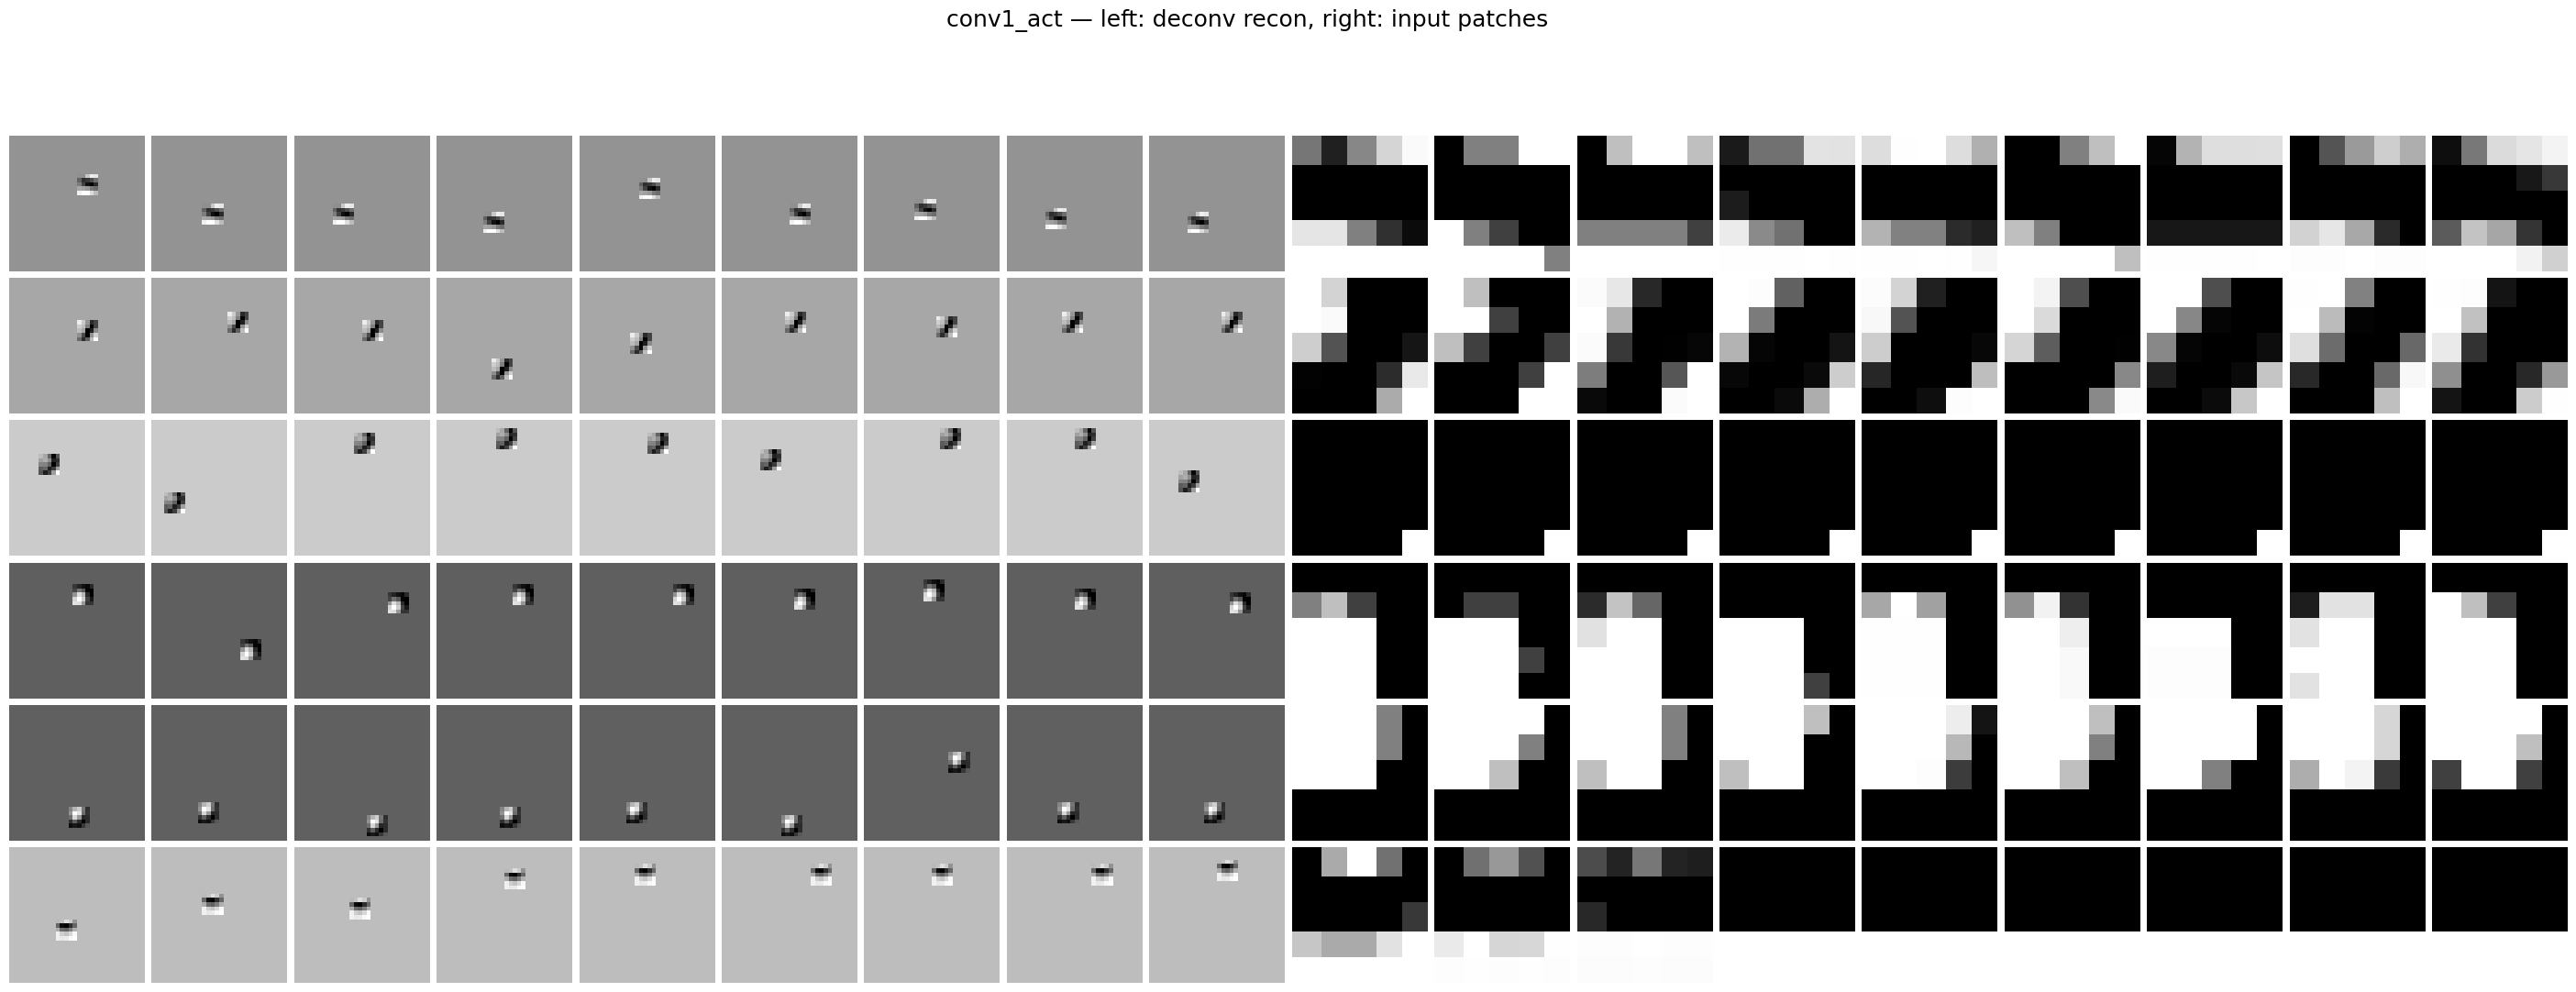

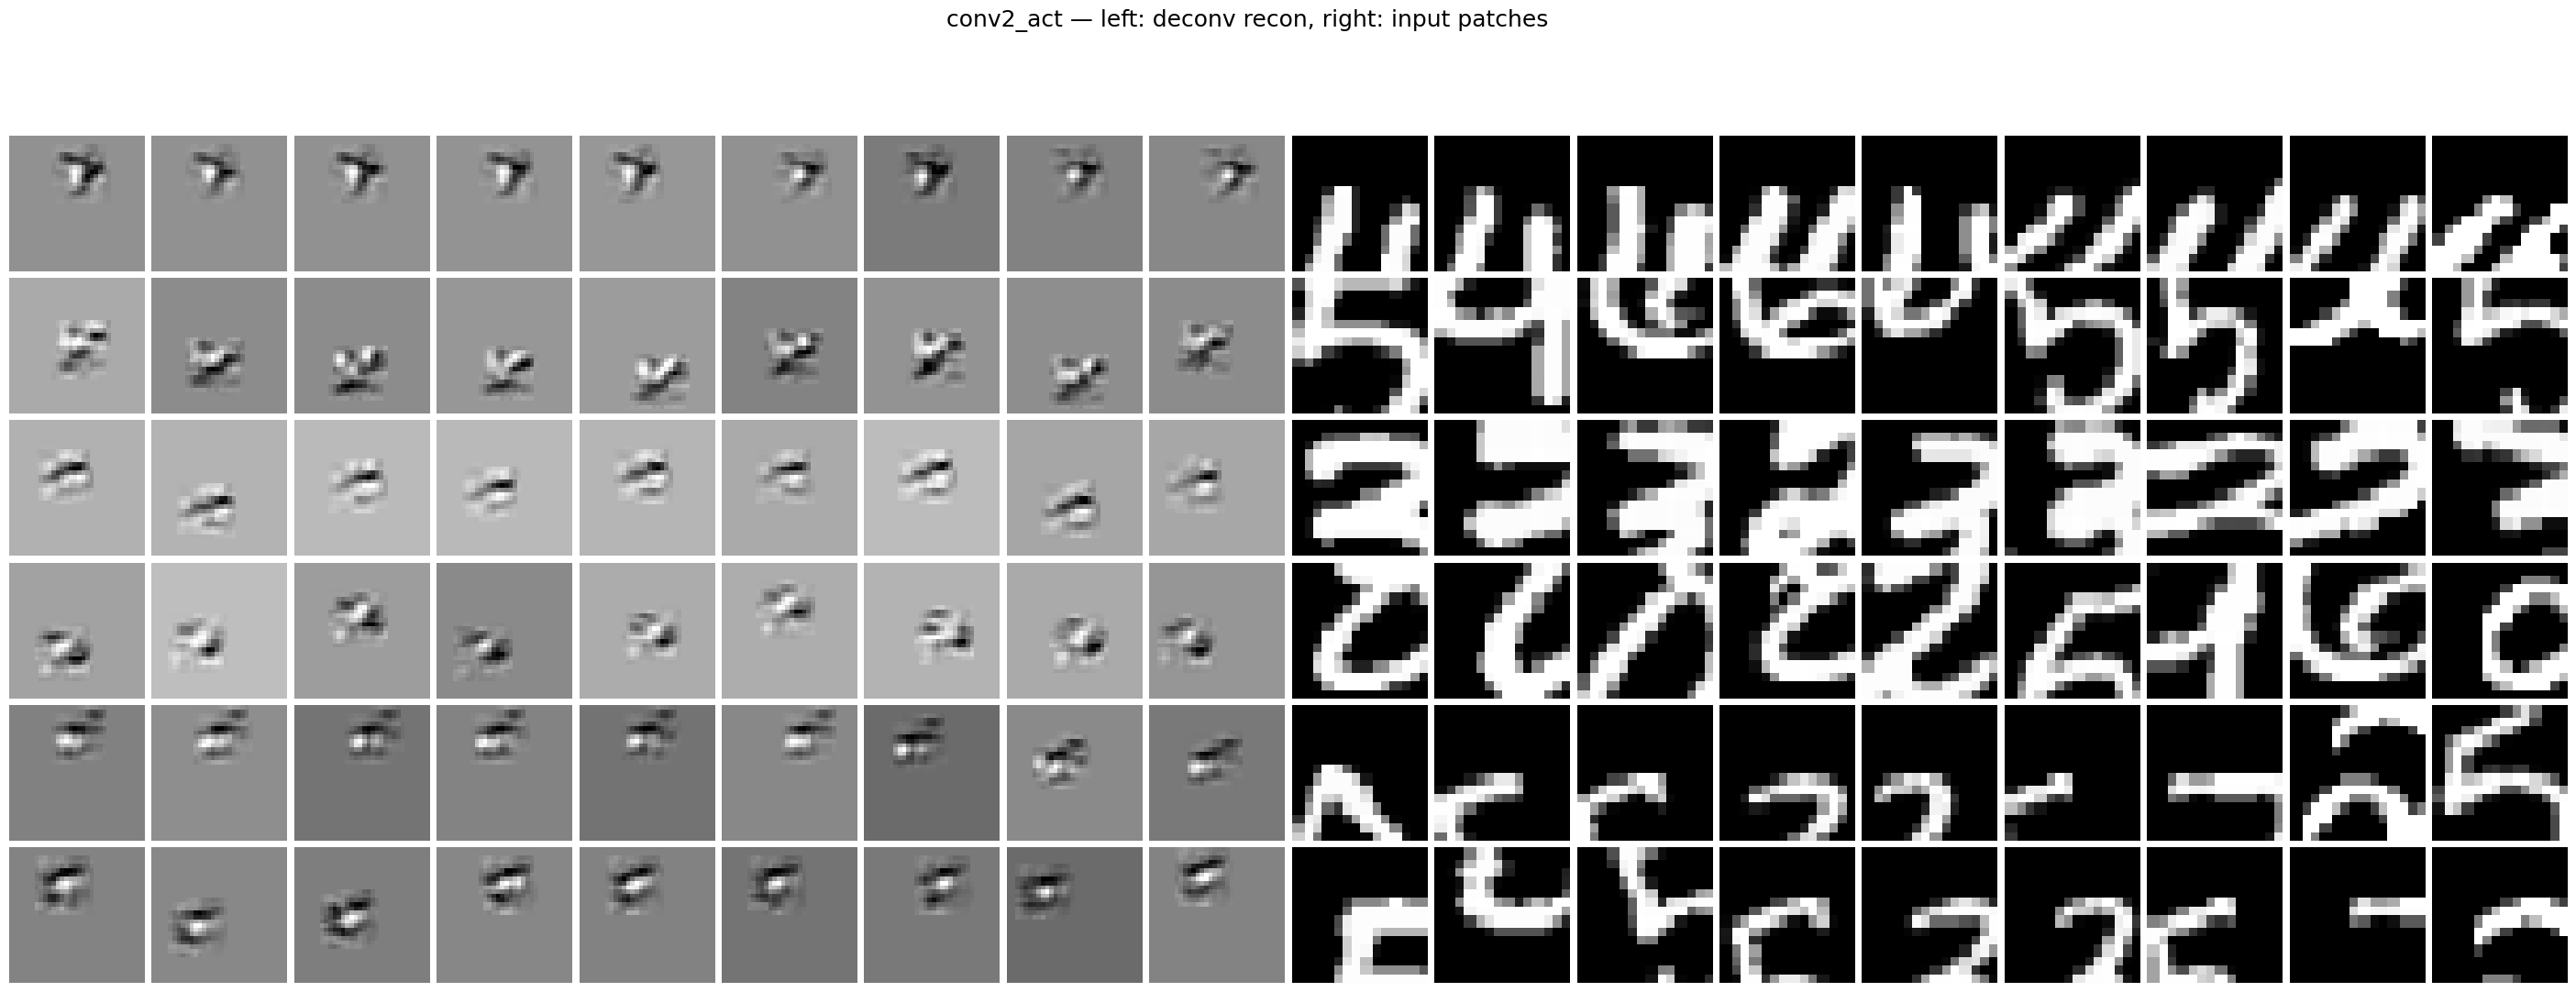

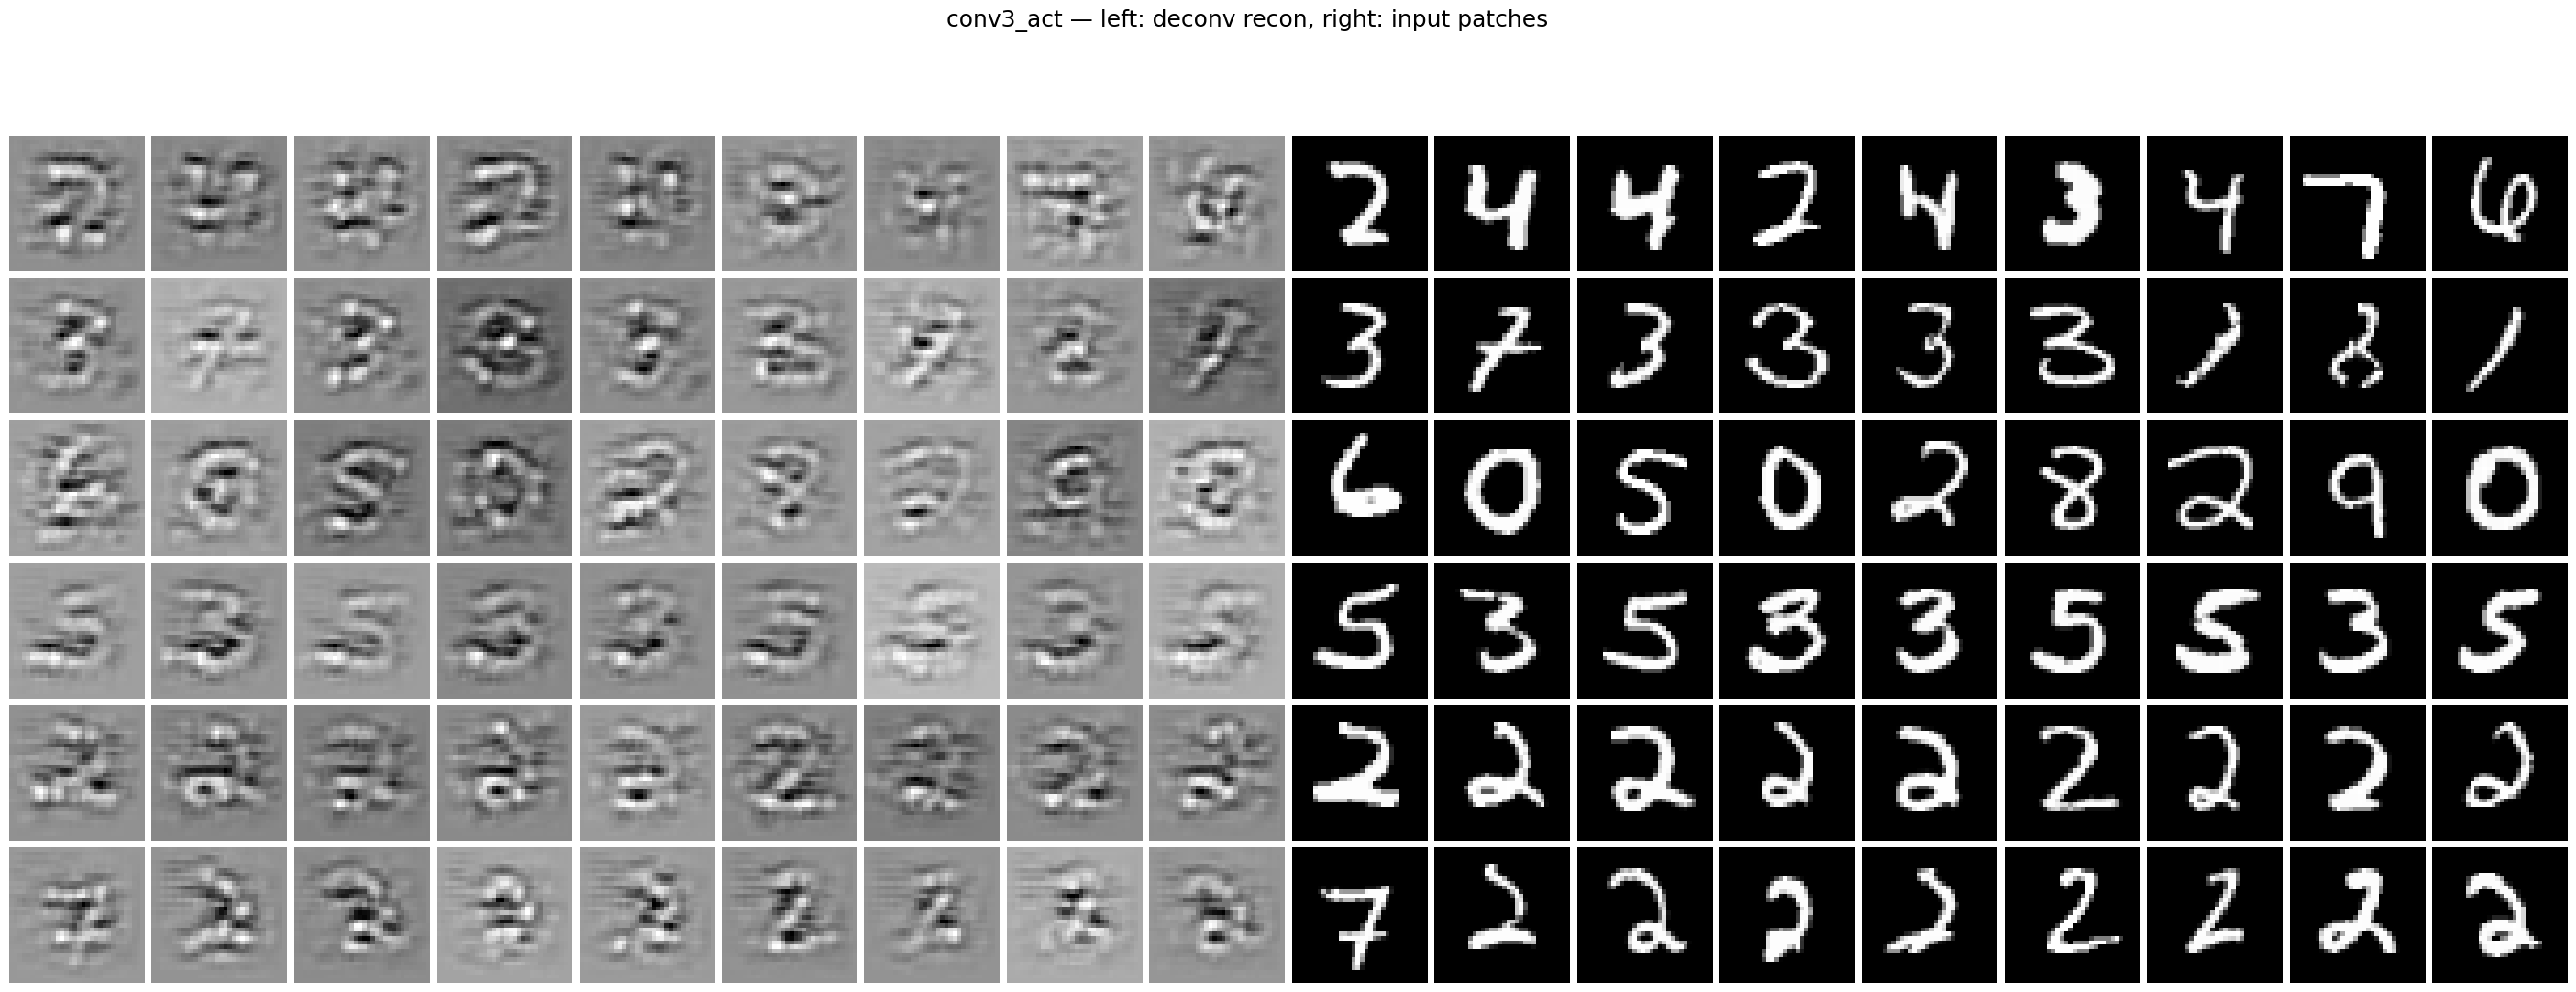

In [10]:
viz = Visualiser(vis, device)

for layer in ["conv1_act","conv2_act","conv3_act"]:
    _ = viz.figure_layer(test_loader, layer_name=layer,
                          n_maps=6, k_per_map=9, max_batches=120, show=True)
